# Прогнозирование температуры звезды


Необходимо придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами: закон смещения Вина, закон Стефана-Больцмана, спектральный анализ. Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным. В нашем распоряжении следующие характеристики:

Относительная светимость L/Lo — светимость звезды относительно Солнца;
Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца;
Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды;
Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа;
Тип звезды:
Коричневый карлик 0
Красный карлик 1
Белый карлик 2
Звёзды главной последовательности 3
Сверхгигант 4
Гипергигант 5
Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

Цель работы: разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.

Этапы работы:

Знакомство с данными (загрузка)

Анализ и предобработка данных

Построение базовой нейросети

Улучшение прошлой версии нейросети

Выводы

## Загрузка данных

Загрузка библиотек.

In [1]:
!pip install phik -q

In [2]:
!pip install sweetviz -q

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import sweetviz as sv
import phik
from phik.report import plot_correlation_matrix
from phik import report
from math import ceil


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.utils import shuffle

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

np.random.seed(0)
pd.set_option('display.max_columns', None)

Загрузка датасета.

In [22]:
data = pd.read_csv('/datasets/6_class.csv', index_col=0)
data.head(5)

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


In [24]:
display(data.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
Temperature (K),240.0,10497.462500,9552.425037,1939.00000,3344.250000,5776.0000,15055.5000,40000.00
Luminosity(L/Lo),240.0,107188.361635,179432.244940,0.00008,0.000865,0.0705,198050.0000,849420.00
Radius(R/Ro),240.0,237.157781,517.155763,0.00840,0.102750,0.7625,42.7500,1948.50
Absolute magnitude(Mv),240.0,4.382396,10.532512,-11.92000,-6.232500,8.3130,13.6975,20.06
Star type,240.0,2.500000,1.711394,0.00000,1.000000,2.5000,4.0000,5.00


Выводы

В данных мы сильно ограничены. Возможно, понадобится аугментация.

Названия столбцов не соответствуют PEP8.

Пропусков в данных нет.

## Предобработка и анализ данных

Приведем названия столбцов к единому стилю:

In [25]:
data.columns = ['temperature', 'luminosity', 'radius', 'abs_magnitude', 'star_type', 'star_color']

Проверим на наличие пропусков и дубликатов:

In [26]:
data.isna().sum()

temperature      0
luminosity       0
radius           0
abs_magnitude    0
star_type        0
star_color       0
dtype: int64

In [27]:
data.duplicated().sum()

0

Проверим корректность категориальных данных.

In [28]:
def uniqueness(colomn_list, df):
    '''Просмотр уникальных значений листа'''
    for column in colomn_list:
        print(f'Количество уникальных значений столбца {column}: {df[column].nunique()}')
        print(df[column].unique())
        print('-----------------------------')

In [29]:
uniqueness(['star_type', 'star_color'], data)

Количество уникальных значений столбца star_type: 6
[0 1 2 3 4 5]
-----------------------------
Количество уникальных значений столбца star_color: 19
['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'Blue ' 'yellowish' 'Yellowish'
 'Orange-Red' 'Blue white ' 'Blue-White']
-----------------------------


Поработаем с неявными дубликатами.

In [30]:

data['star_color'] = data['star_color'].replace('blue white', 'blue-white')
data['star_color'] = data['star_color'].replace(['yellow-white', 'yellowish white'], 'white-yellow')
data['star_color'] = data['star_color'].str.lower()
data['star_color'] = data['star_color'].str.strip(to_strip = None)
uniqueness(['star_type', 'star_color'], data)

Количество уникальных значений столбца star_type: 6
[0 1 2 3 4 5]
-----------------------------
Количество уникальных значений столбца star_color: 12
['red' 'blue white' 'white' 'yellowish white' 'pale yellow orange' 'blue'
 'blue-white' 'whitish' 'white-yellow' 'orange' 'yellowish' 'orange-red']
-----------------------------


По результатам предобработки данных были исправлены ошибки в столбце Star color, связанные с неявными дубликатами в словах, что позволило сократить количество уникальных значений с 19 до 12 штук. Явные дубликаты не были обнаружены.

### EDA

Посмотрим распределение данных в столбцах методом sweetwiz.

                                             |          | [  0%]   00:00 -> (? left)


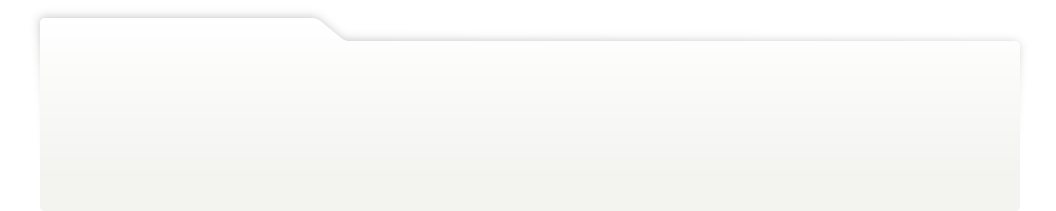
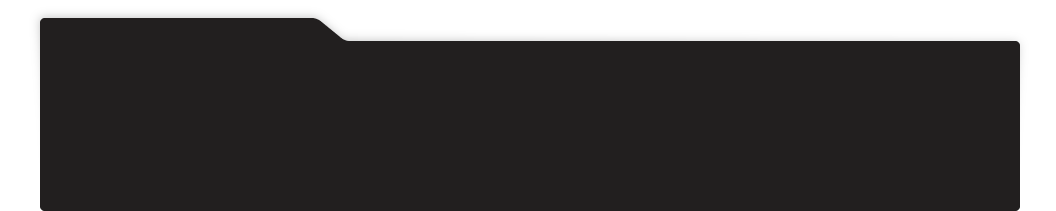
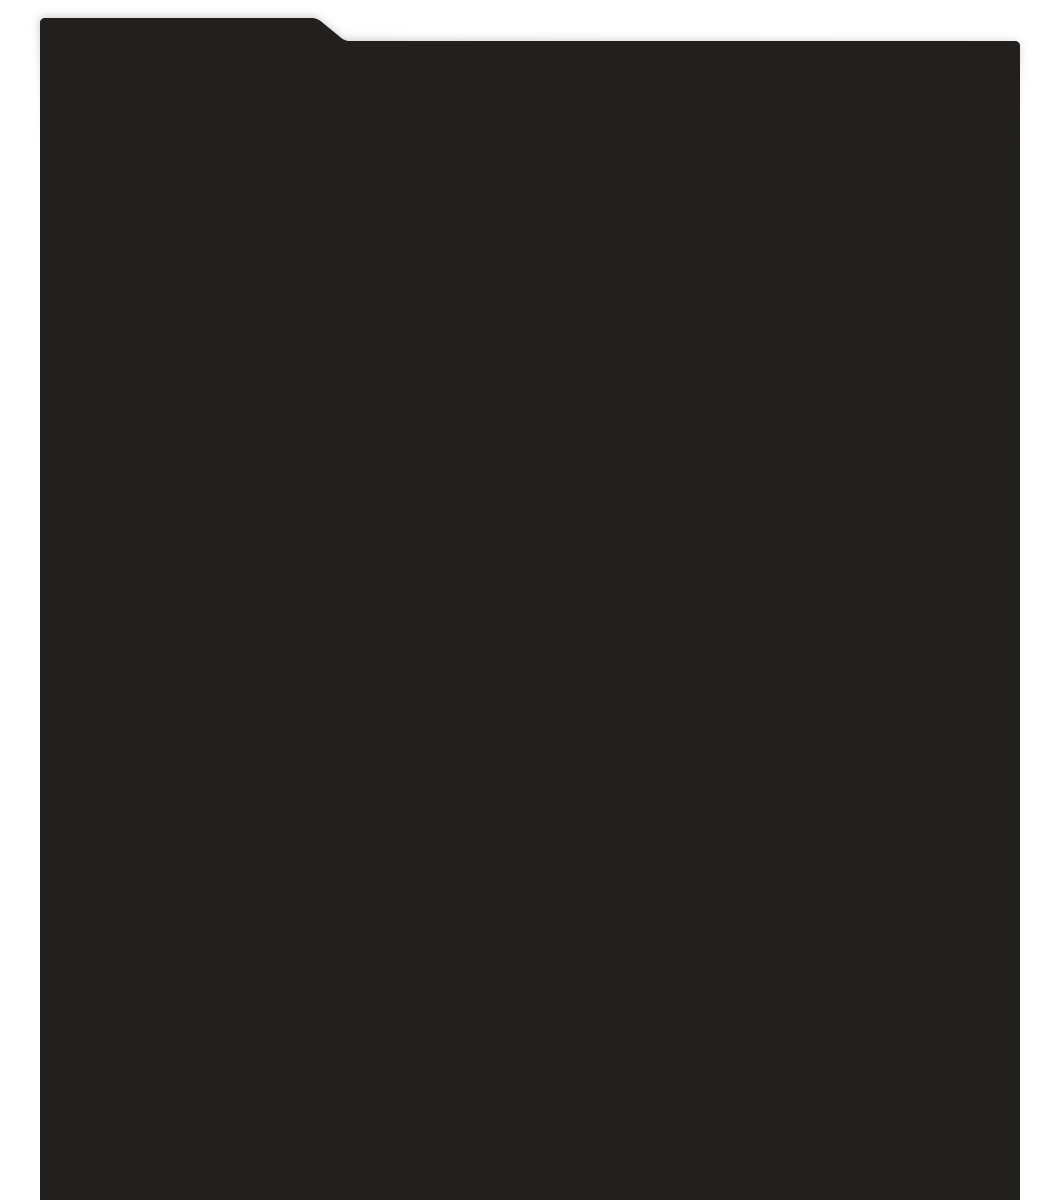
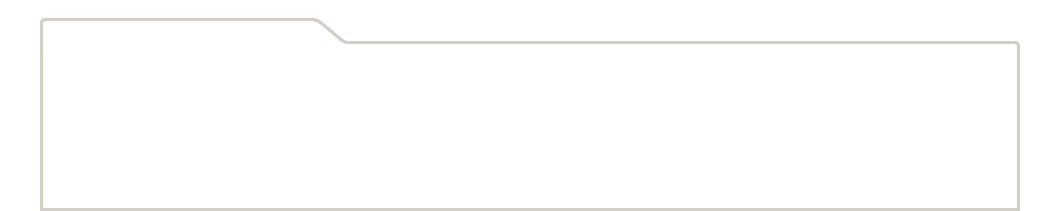
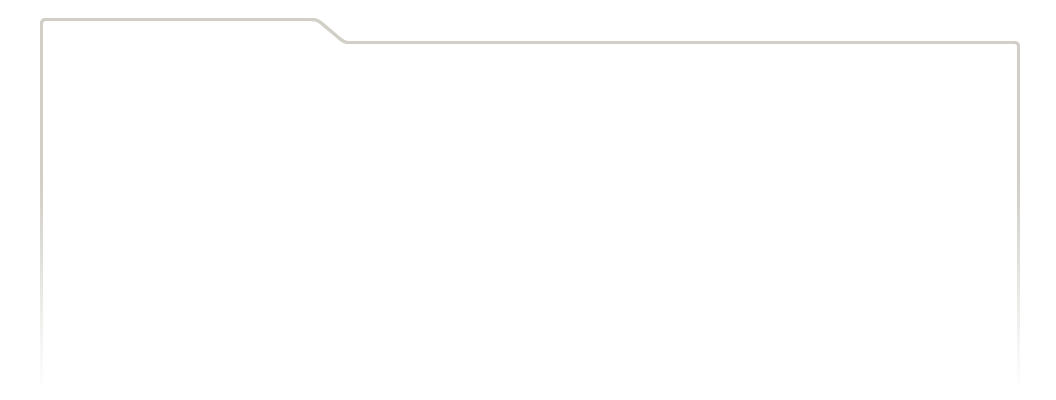
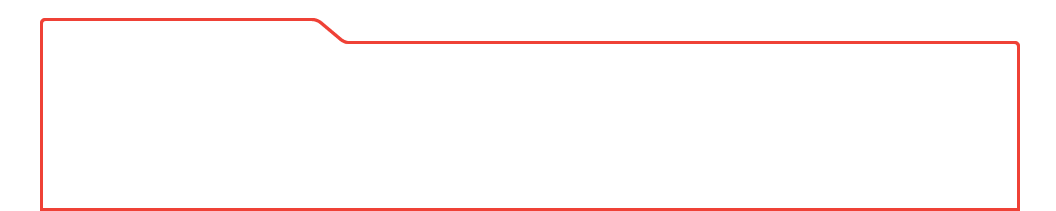
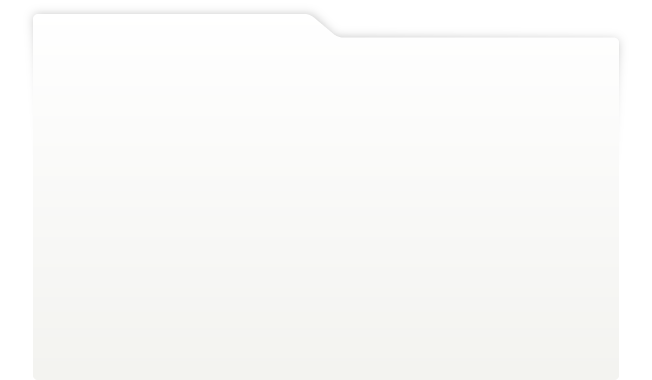
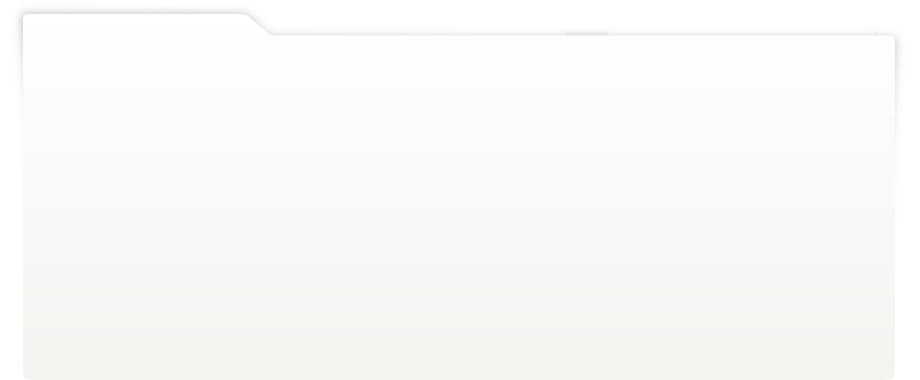
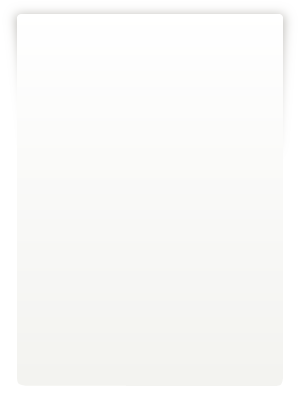
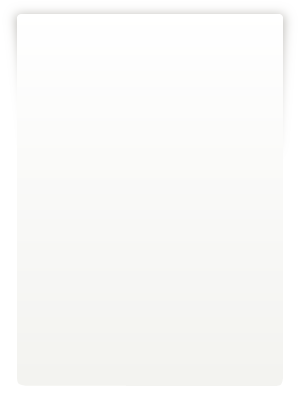
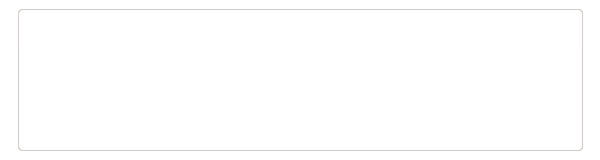
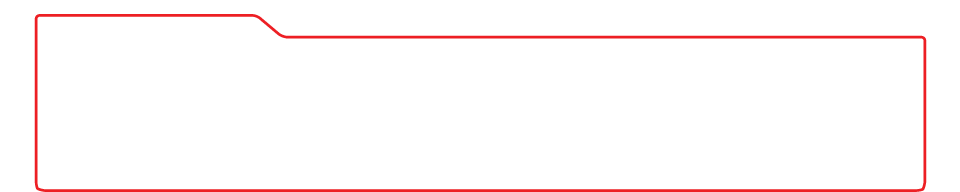
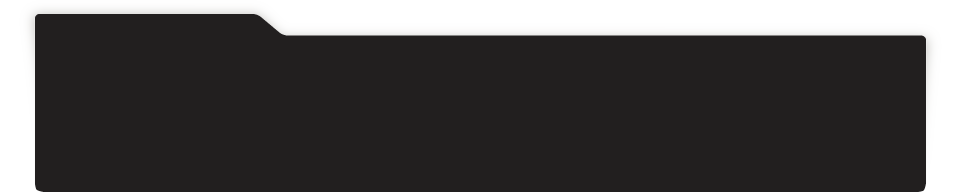
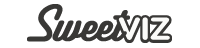
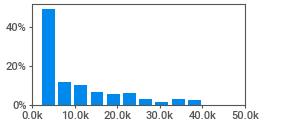
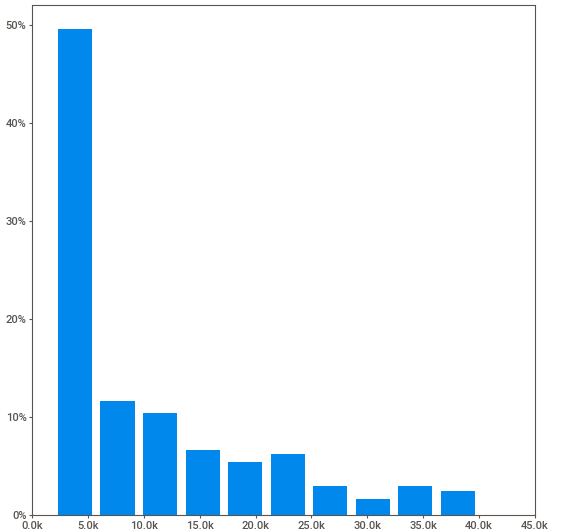
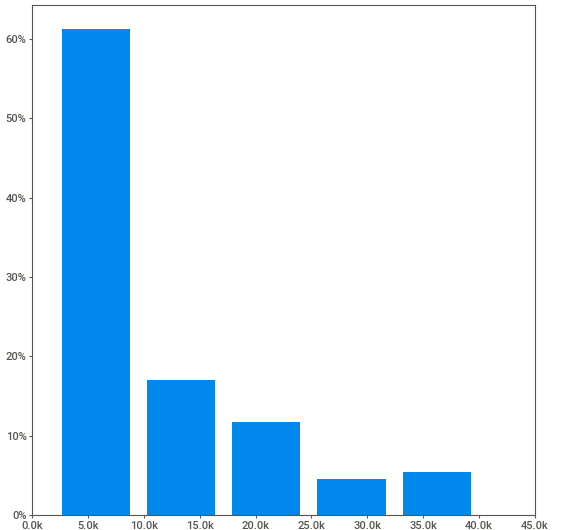
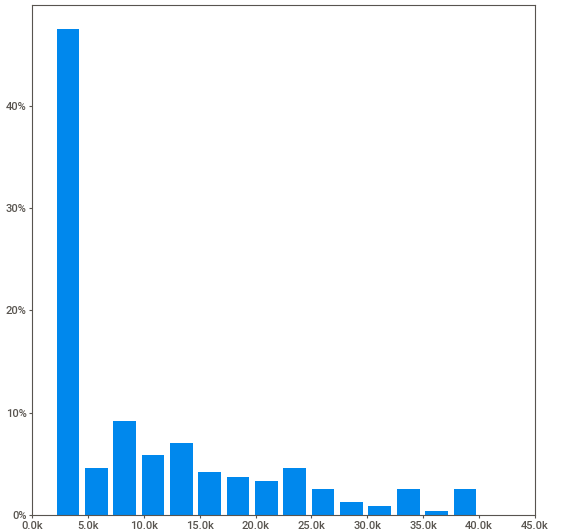
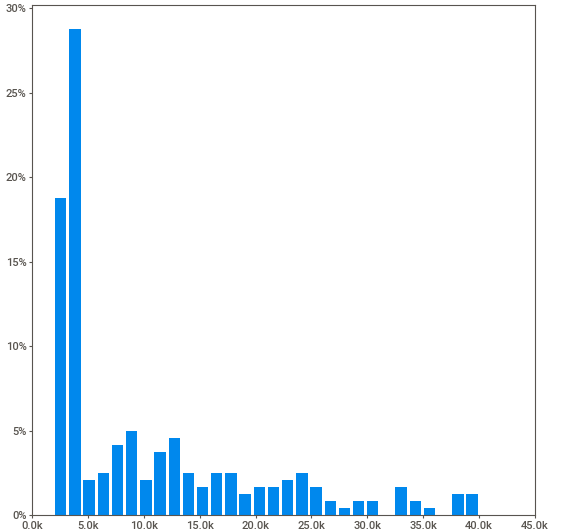
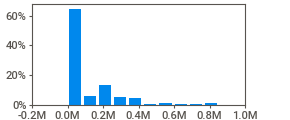
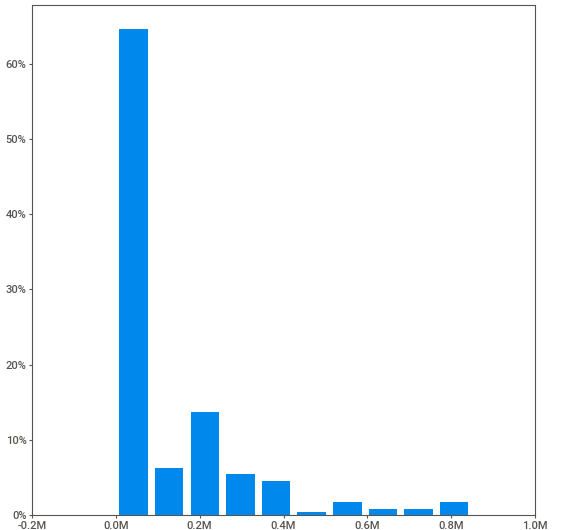
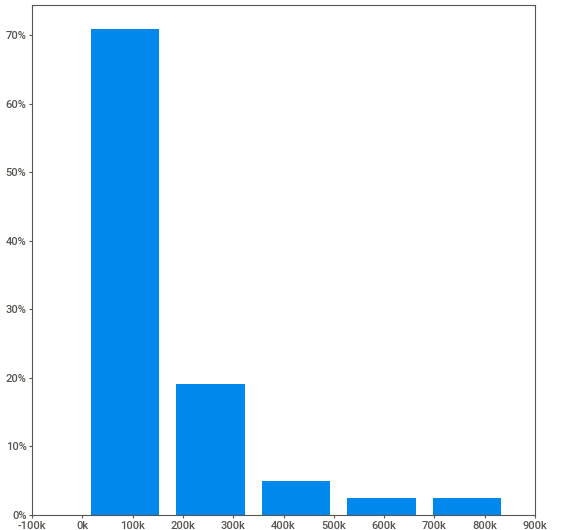
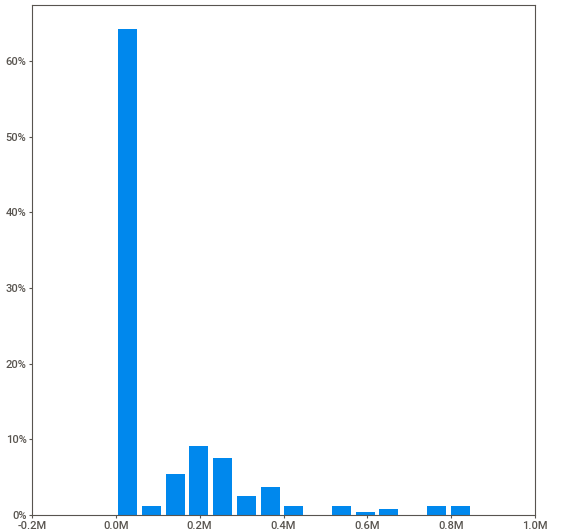
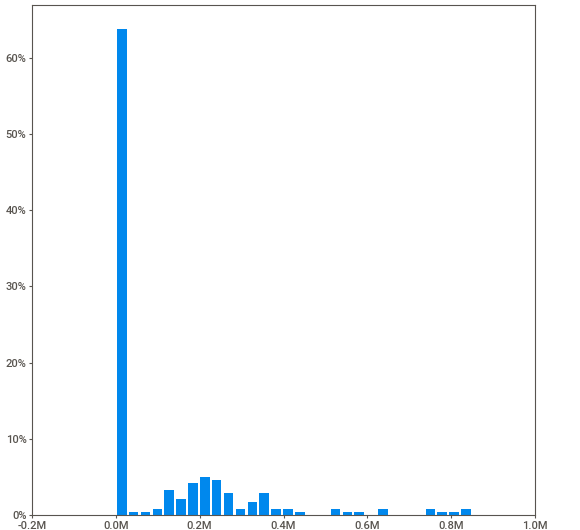
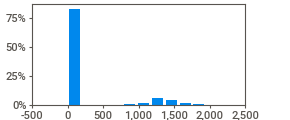
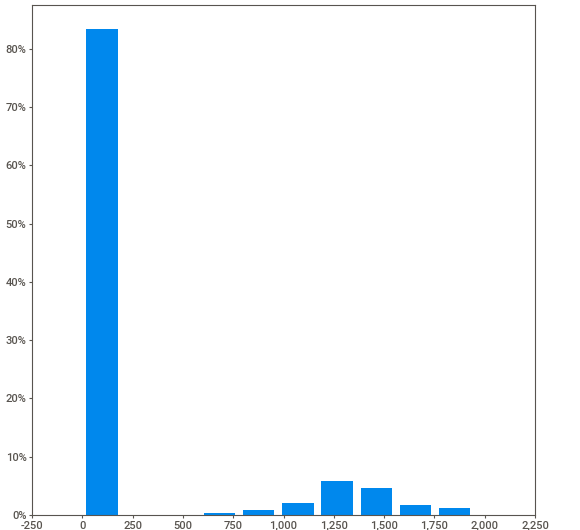
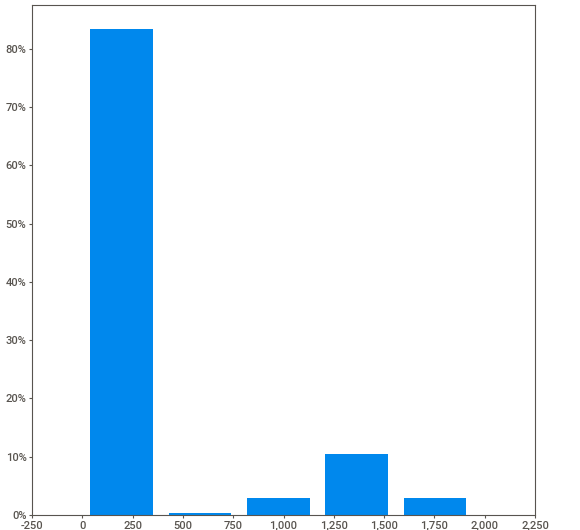
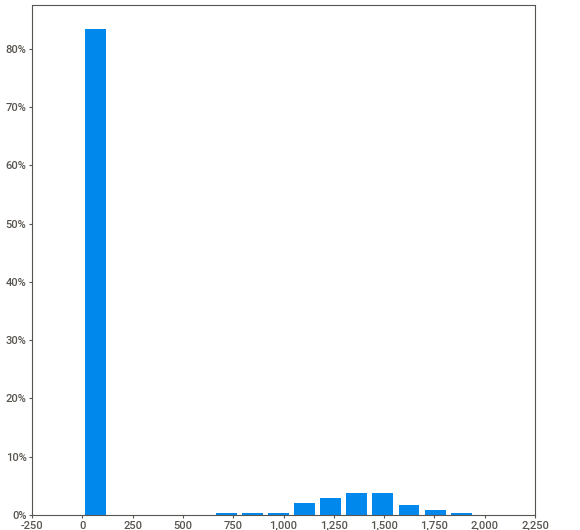
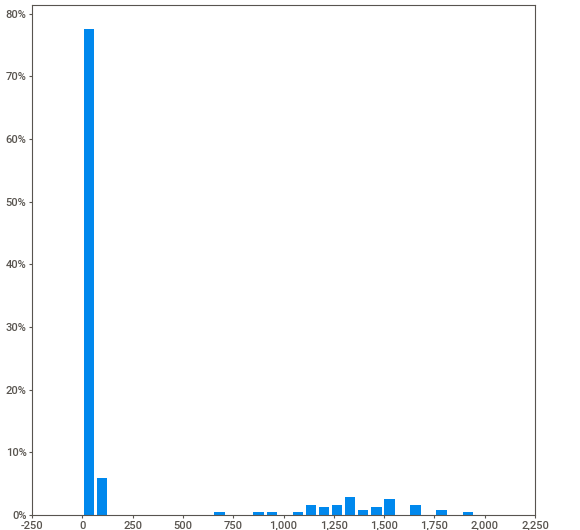
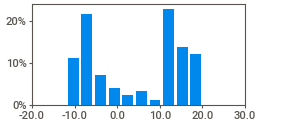
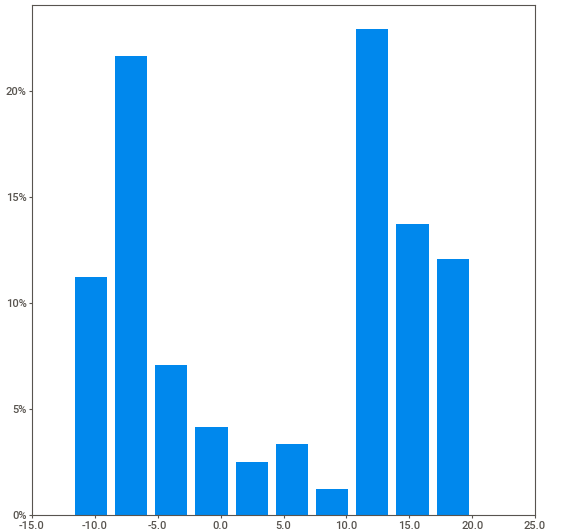
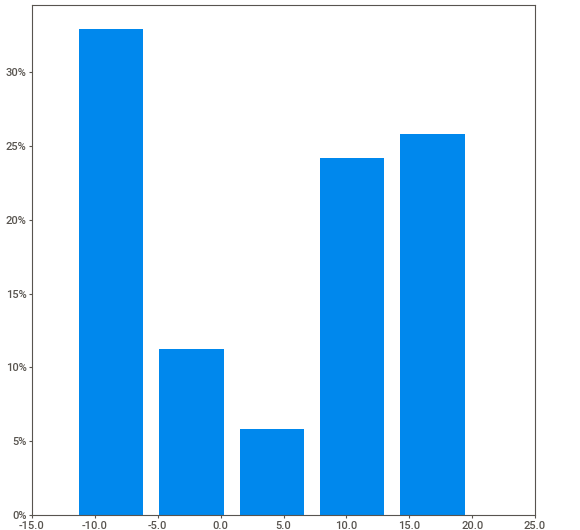
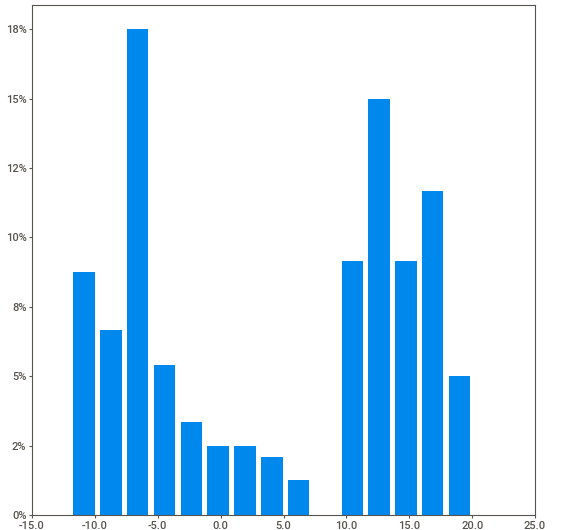
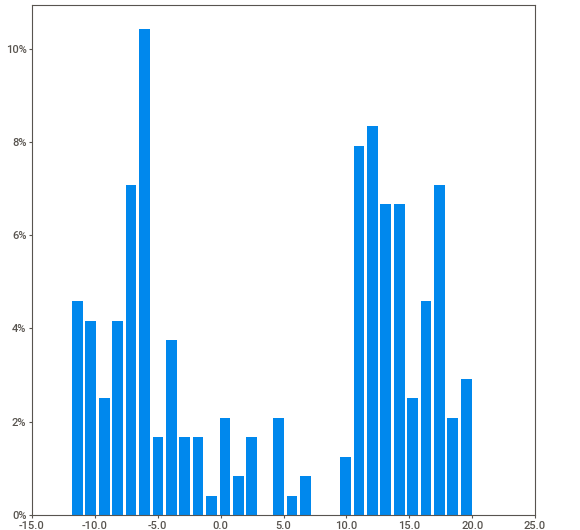
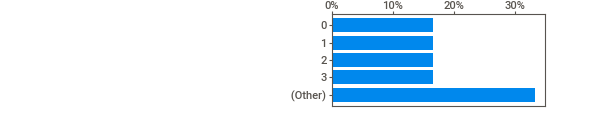
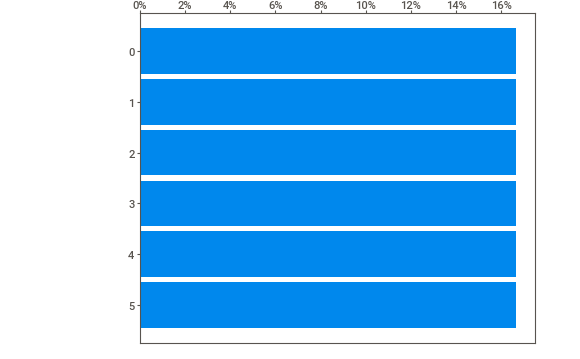
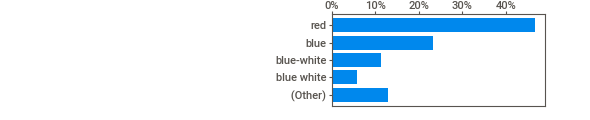
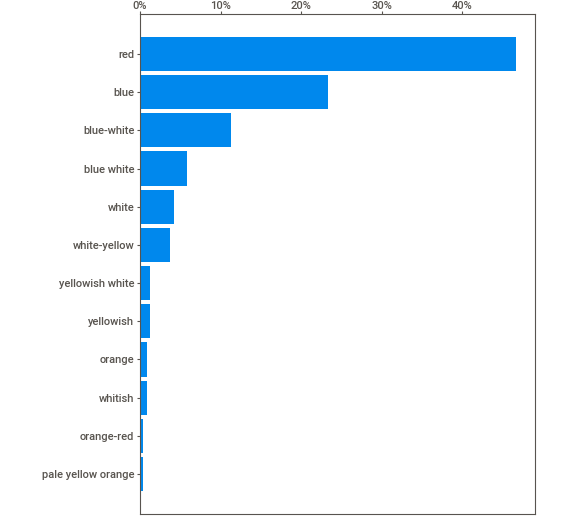
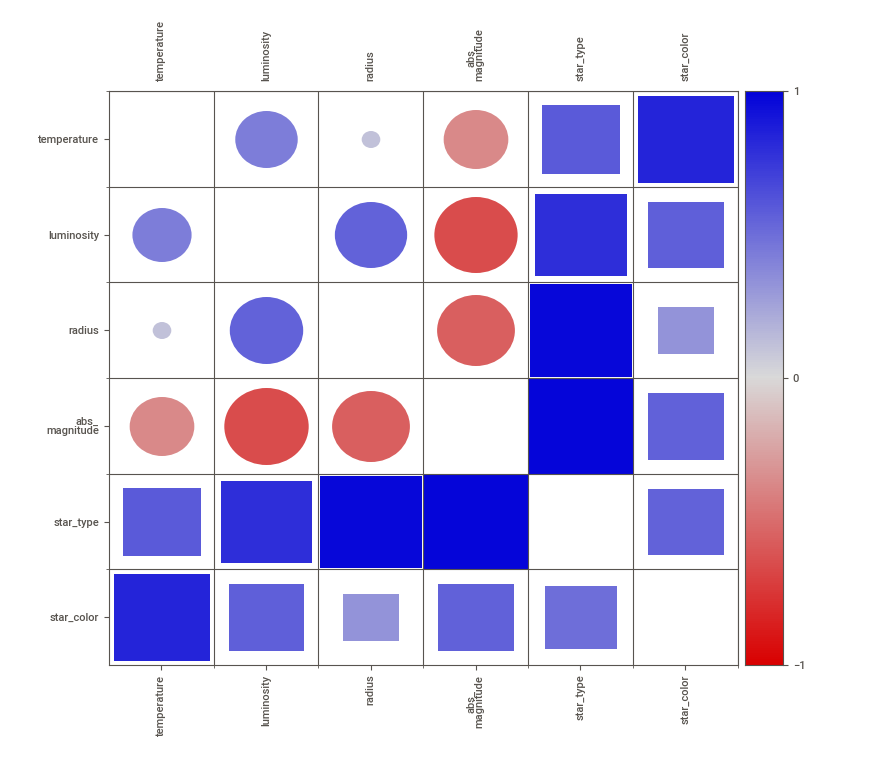
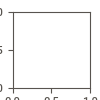

In [31]:
my_report = sv.analyze(data)
my_report.show_notebook(  w=None, 
                h=None, 
                scale=None,
                layout='widescreen',
                filepath=None)

На первый взгляд, кажется, что никаких аномалий на графиках нет. В данных преобладают звезды с относительно низкими показателями температуры на поверхности, низкой светимостью относительно Солнца и малого радиуса относительно радиуса Солнца. Цвет звезд представлен несбалансировано, в данных преобладают красные, голубые и бело-голубые звезды. Каждому типу соответсвует одинаковое количество звезд  - 40.

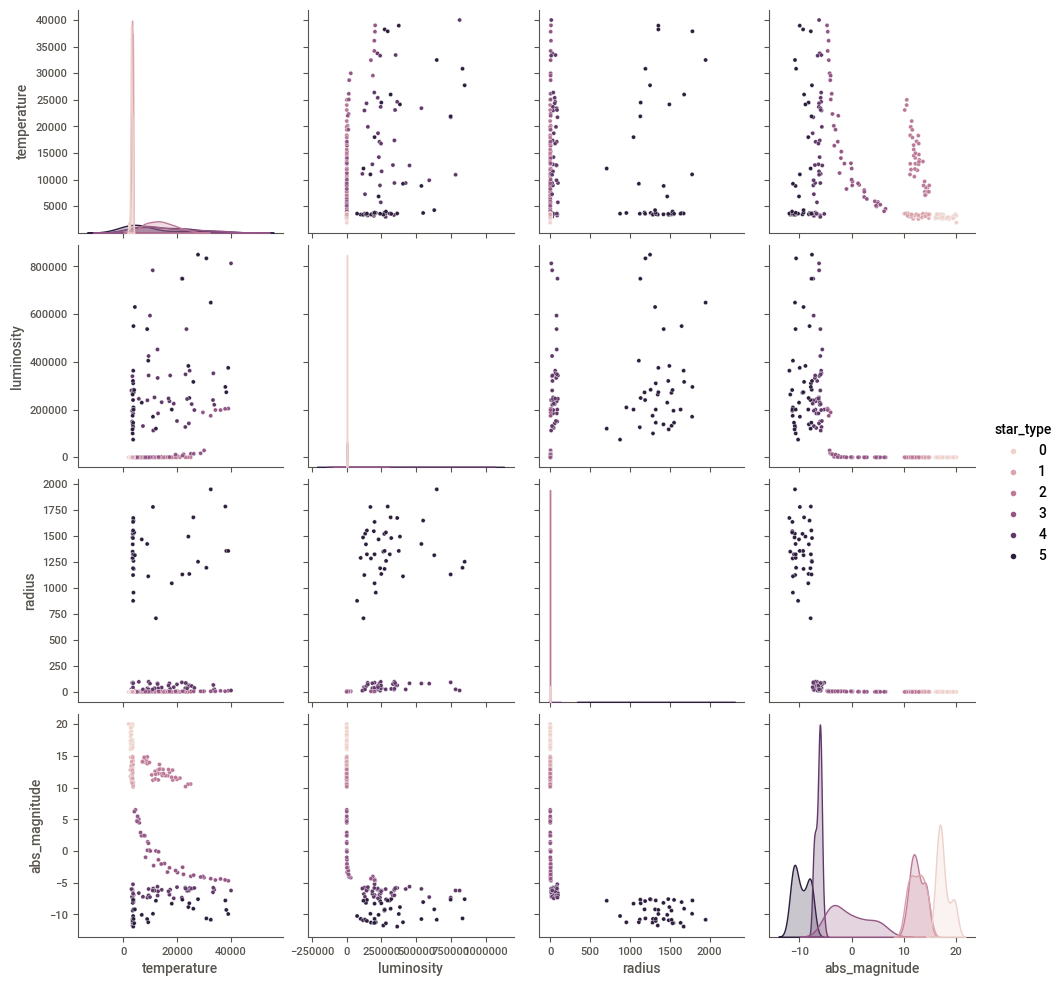

In [32]:
sns.pairplot(data, hue='star_type');

С увеличением температуры начинает уменьшаться абсолютная звёздная величина (магнитуда).
При помощи радиуса можно выделить тип звезды.
Хорошо выделяются кластеры типа звезды в зависимости абсолютной звёздой величины.

Определим функцию для построения графиков распределения и boxplot:

In [33]:
def distr(data, title, x, y):
    plt.figure(figsize=(5, 4))
    sns.histplot(data=data, kde=True, bins=50)
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()


    plt.figure(figsize=(8, 1))
    sns.boxplot(x=data)
    plt.xlabel(x)
    plt.show()

Построим графики для всех числовых значений:

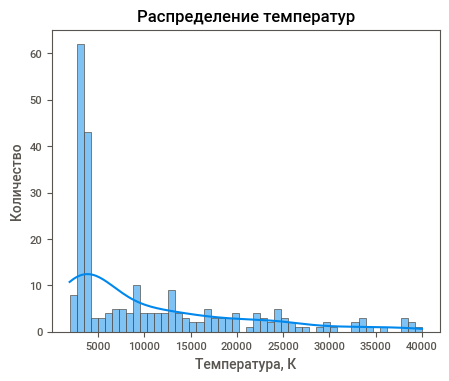

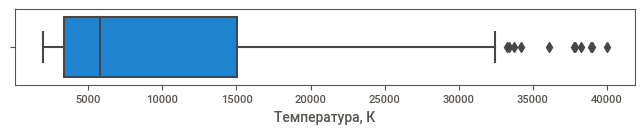

In [34]:
distr(data['temperature'], 'Распределение температур', 'Температура, К', 'Количество')

В основном выделяется температура звезд менее 5000 К, при этом длиннохвостовое распределение дает показатели среднего почти в 10000 К.

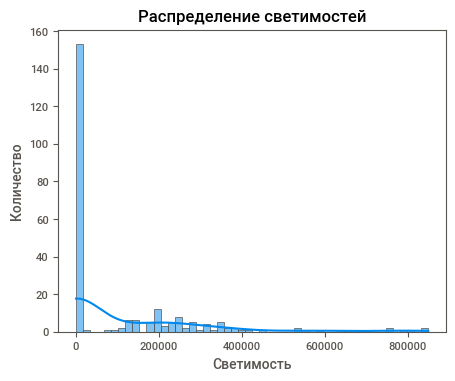

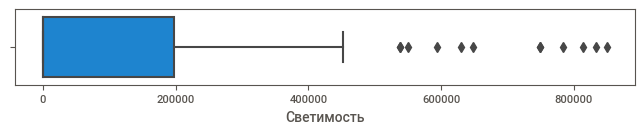

In [35]:
distr(data['luminosity'], 'Распределение светимостей', 'Светимость', 'Количество')

Видим пик около нуля, что указывает на большое кол-во звезд с малой светимостью.

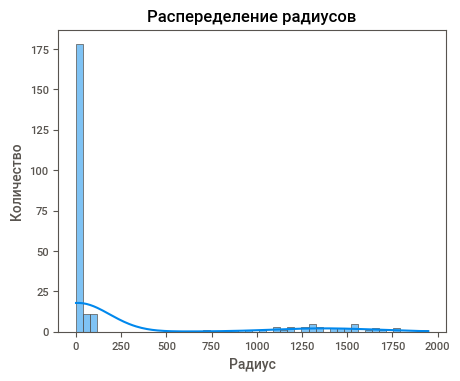

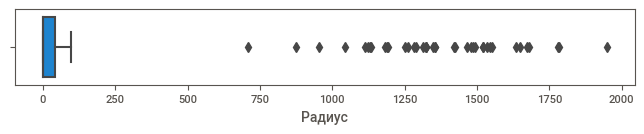

In [36]:
distr(data['radius'], 'Распеределение радиусов', 'Радиус', 'Количество')

Можем наблюдать длиннохвостовое распределение, т.е. большое различие в радиусах звезд.

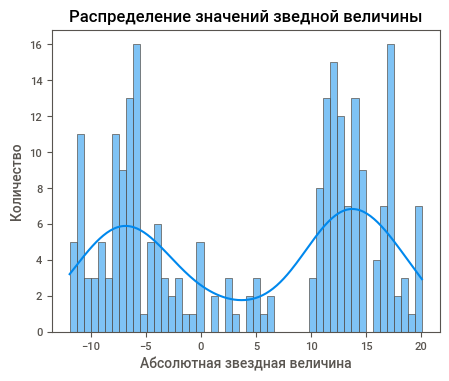

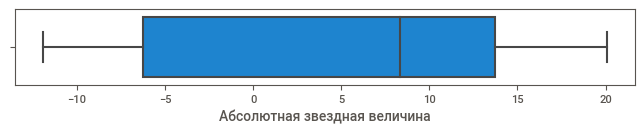

In [37]:
distr(data['abs_magnitude'], 'Распределение значений зведной величины', 'Абсолютная звездная величина', 'Количество')

Признак без выбросов, который имеет бимодальное распределение, практически зеркальное в отрицательной и положительной частях графика. 

Посмотрим корреляюцию методом phik.

interval columns not set, guessing: ['temperature', 'luminosity', 'radius', 'abs_magnitude', 'star_type']


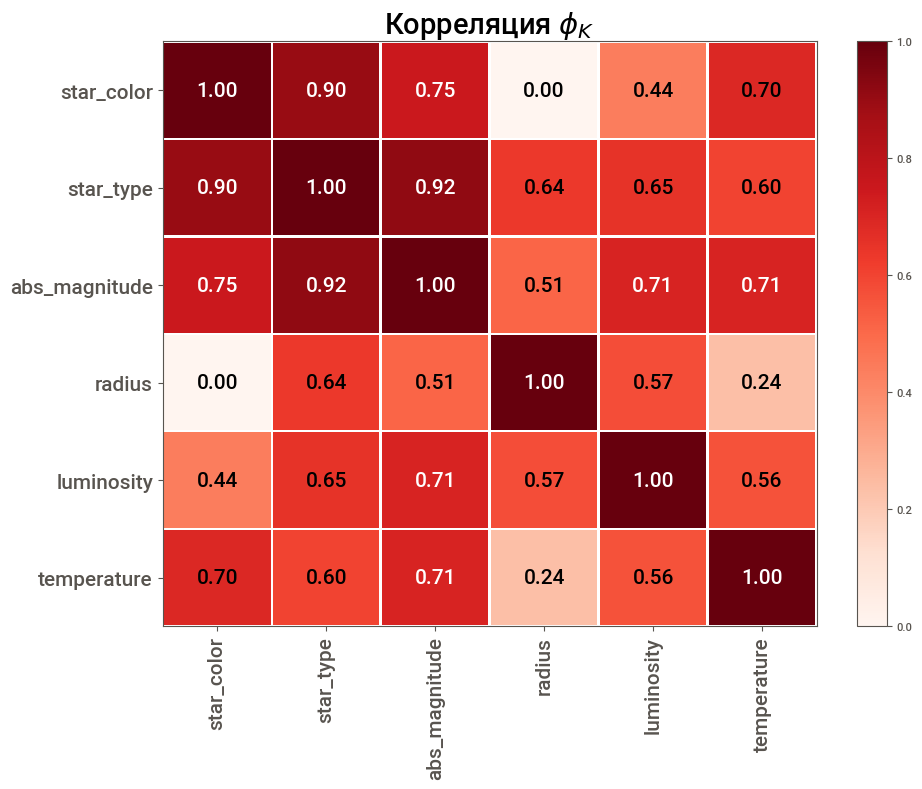

In [38]:
phik_overview = data.phik_matrix()
phik_overview.round(2)

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Reds", 
                        title=r"Корреляция $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout()
plt.show()

Посмотрим на статистическую значимость.

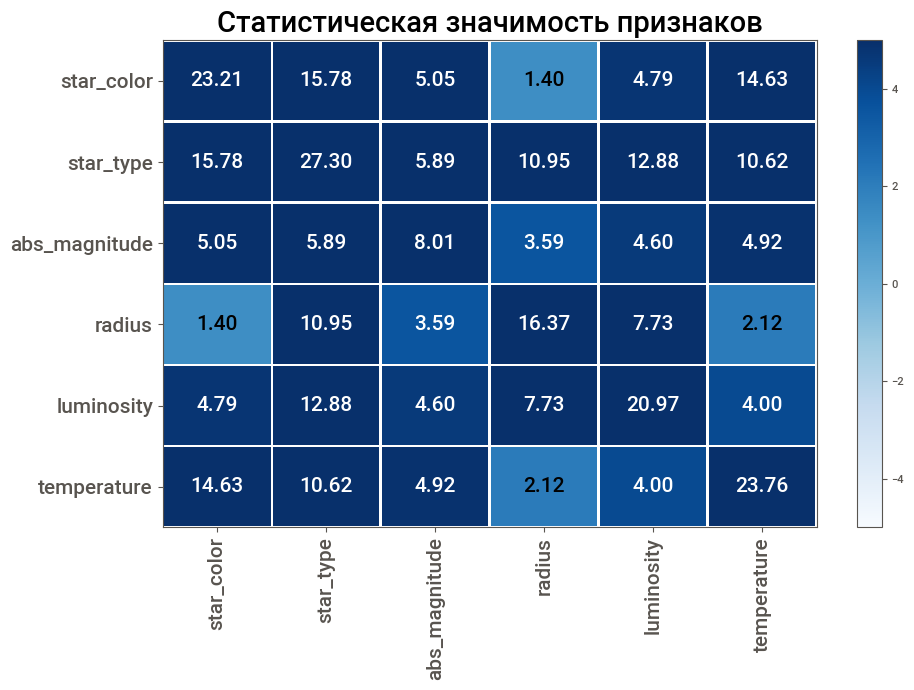

In [39]:
significance_overview = data.significance_matrix(interval_cols=['temperature', 'luminosity', 'radius', 'absolute_magnitude', 'star_type'])
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-5, vmax=5, title="Статистическая значимость признаков", 
                        usetex=False, fontsize_factor=1.5, figsize=(10, 7), color_map="Blues")
plt.tight_layout()

Посмотрим корреляцию по целевому признаку.

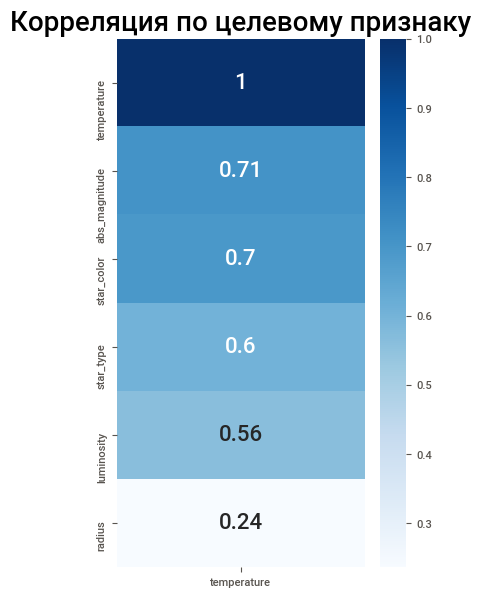

In [40]:
plt.figure(figsize=(4, 7))
sns.heatmap(phik_overview.sort_values(by = 'temperature', ascending=False)[['temperature']], cmap='Blues', annot=True, annot_kws={'size':16}, fmt='.2g')
plt.title('Корреляция по целевому признаку', fontsize=20)
plt.show()

Аномалий на графиках нет. В данных преобладают звезды с относительно низкими показателями температуры на поверхности, низкой светимостью относительно Солнца и малого радиуса относительно радиуса Солнца. Цвет звезд представлен несбалансировано, в данных преобладают красные, голубые и бело-голубые звезды. Каждому типу соответсвует одинаковое количество звезд - 40. В основном все распределения жирнохвостовые. С увеличением температуры начинает уменьшаться абсолютная звёздная величина (магнитуда). При помощи радиуса можно выделить тип звезды. Хорошо выделяются кластеры типа звезды в зависимости абсолютной звёздой величины. Дополнительная обработка признаков не требуется.

Отмечается мультикорреляция между столбцом Star type и Absolute magnitude(Mv), равная 92% по корреляции phik. 

Рассмотрим взаимосвязь целевого показателя с признаками:

luminosity - 56% корреляция. В любой статье можно наткнуться на слова о том, что главным фактором температуры звезды является его цвет, но фактически светимость звезды относительно Солнца позволяет нам понять насколько звезда теплая, хоть и не явно.

absolute_magnitude - 71% корреляция. Это физическая величина, характеризующая блеск астрономического объекта для наблюдателя, находящегося на некотором стандартном расстоянии от объекта. Использование абсолютной звёздной величины позволяет сравнивать действительную, а не наблюдаемую светимость объектов. Поэтому она очень схожа с понятием относительная светимость.

star_color - 69% корреляция. Как я уже писал выше, одним из важнейших показателей температуры звезды является его цвет, скорее всего это вызвано преломлением светового луча, который доходит до нашей планеты.

star_type - 60% корреляция с основным признаком. По пяти основным типам звезд возможно понять их температуру, с точки зрения статистики и наблюдений.

radius - самая маленькая корреляция, равная всего 24%. Возможно это связано с природой, а точнее с плотностью и массой звёзд, ведь не важно какой объект будет по размерам, важнее из чего он состоит и каким цветом будет светить.


## Построение базовой нейронной сети

###  Подготовка данных

Разделим выборку.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('temperature', axis = 1),
                                                    data['temperature'],
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(192, 5) (48, 5) (192,) (48,)


Проведем обработку категориальных данных с помощью OneHotEncoder и масштабирование числовых признаков.

In [42]:
numeric = ['luminosity', 'radius', 'abs_magnitude']

scaler = StandardScaler()
scaler.fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

In [43]:
categorial = ['star_color', 'star_type']

tmp_train = X_train[categorial]
tmp_test= X_test[categorial]


encoder_ohe = OneHotEncoder(handle_unknown='ignore')
encoder_ohe.fit(X_train[categorial])

tmp_train = pd.DataFrame(encoder_ohe.transform(X_train[categorial]).toarray(), 
                                   columns=encoder_ohe.get_feature_names(),
                                   index=X_train.index)
tmp_test = pd.DataFrame(encoder_ohe.transform(X_test[categorial]).toarray(), 
                                   columns=encoder_ohe.get_feature_names(),
                                   index=X_test.index)

X_train.drop(categorial, axis=1, inplace=True)
X_train = X_train.join(tmp_train)

X_test.drop(categorial, axis=1, inplace=True)
X_test = X_test.join(tmp_test)

Проверим данные после разделения и кодирования.

In [45]:
print(f'Доля тренировочных признаков: {X_train.shape[0]/data.shape[0]:.2f}')
print(f'Доля тренировочных целей: {y_train.shape[0]/data.shape[0]:.2f}')
print(f'Доля тестовых признаков: {X_test.shape[0]/data.shape[0]:.2f}')
print(f'Доля тестовых целей: {y_test.shape[0]/data.shape[0]:.2f}')

Доля тренировочных признаков: 0.80
Доля тренировочных целей: 0.80
Доля тестовых признаков: 0.20
Доля тестовых целей: 0.20


### Построение базовой нейронной сети

Cоздаем тензоры признаков:

In [46]:
X_train = torch.FloatTensor(np.array(X_train))
X_test = torch.FloatTensor(np.array(X_test))
y_train = torch.FloatTensor(np.array(y_train))
y_test = torch.FloatTensor(np.array(y_test))

In [47]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
            super(Net, self).__init__()
            
            self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
            self.act1 = nn.ReLU()
            self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
            self.act2 = nn.ReLU()
            self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

            
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)

        return x

Настраиваем количество нейронов на слоях сети.

In [48]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 12
n_hidden_neurons_2 = 8
n_out_neurons = 1

In [49]:
net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss = nn.MSELoss()

In [50]:
dataset_train = torch.utils.data.TensorDataset(X_train, y_train)
dataset_test = torch.utils.data.TensorDataset(X_test, y_test)

train_dataloader = DataLoader(dataset_train, batch_size=40, shuffle=True,
                              num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=40, num_workers=0) 

In [51]:
class CustomEarlyStopping():
    """
    Ранняя остановка, чтобы остановить тренировку, когда потеря не улучшается после определенной эпохи.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: сколько эпох ждать, прежде чем остановиться, когда потеря не улучшается
        :param min_delta: минимальная разница между loss/метриками, если улучшений нет, то остановим обучение
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

Обучение нейросети.

In [52]:
early_stopping = CustomEarlyStopping(patience=5, min_delta=20)

num_epochs = 100001
for epoch in range(num_epochs):
    net.train()
    for batch in train_dataloader:
        data_train, temperature_train = batch # просто выгружаем данные 
        optimizer.zero_grad()

        preds = net.forward(data_train).flatten()

        loss_value = torch.sqrt(loss(preds, temperature_train))
        loss_value.backward()
        optimizer.step()
    
    if epoch % 200 == 0:
        predicted_temp = [] 
        with torch.no_grad():
            net.eval()
            for batch in test_dataloader:
                data_test, temperature_test = batch # просто выгружаем данные

                test_preds = net.forward(data_test).flatten()
                predicted_temp.append(test_preds)
                RMSE_loss = torch.sqrt(loss(test_preds, temperature_test))

        predicted_temp = torch.cat(predicted_temp).detach().numpy()
        RMSE = mean_squared_error(y_test, predicted_temp, squared=False)
        early_stopping(RMSE)
        if early_stopping.counter == 0:
            best_rmse = RMSE
            best_predicted_temp = predicted_temp
        print(f"epoch:{epoch}, RMSE test: {RMSE}")

        if early_stopping.early_stop:
            print('Early Stoppning!!!')
            print(f'Best RMSE test {best_rmse}')
            break 

epoch:0, RMSE test: 15201.396484375
epoch:200, RMSE test: 14145.19921875
epoch:400, RMSE test: 9896.482421875
epoch:600, RMSE test: 7733.11767578125
epoch:800, RMSE test: 7209.140625
epoch:1000, RMSE test: 6724.47509765625
epoch:1200, RMSE test: 6264.09326171875
epoch:1400, RMSE test: 5887.9814453125
epoch:1600, RMSE test: 5604.6865234375
epoch:1800, RMSE test: 5414.69775390625
epoch:2000, RMSE test: 5290.68017578125
epoch:2200, RMSE test: 5203.28759765625
epoch:2400, RMSE test: 5140.09130859375
epoch:2600, RMSE test: 5085.14990234375
epoch:2800, RMSE test: 5037.0810546875
epoch:3000, RMSE test: 4996.68212890625
epoch:3200, RMSE test: 4958.5419921875
epoch:3400, RMSE test: 4923.888671875
epoch:3600, RMSE test: 4892.57275390625
epoch:3800, RMSE test: 4866.02587890625
epoch:4000, RMSE test: 4843.1044921875
epoch:4200, RMSE test: 4820.470703125
epoch:4400, RMSE test: 4797.0419921875
epoch:4600, RMSE test: 4773.81396484375
INFO: Early stopping counter 1 of 5
epoch:4800, RMSE test: 4756.598

In [53]:
def vizualization(test_preds, y_test):
    
    '''Функция для визуализации качества регрессии "Факт-прогноз"'''
    
    y1 = torch.FloatTensor(test_preds)
    y1 = y1.detach().numpy().reshape([-1])
    y2 = y_test.detach().numpy().reshape([-1])
    x = np.arange(len(y1))

    fig,ax = plt.subplots()
    fig.set_figwidth(18)
    fig.set_figheight(8)
    ax.set_xticks(x)
    fact = ax.bar(x, y2, width = 0.6, label = 'Факт')
    forecast = ax.bar(x, y1, width = 0.3, label = 'Прогноз')
    ax.legend()
    ax.set_title('График "Факт-прогноз"', fontsize=20)
    ax.set_xlabel('Номер звезды')
    ax.set_ylabel('Температура звезды')
    plt.show()

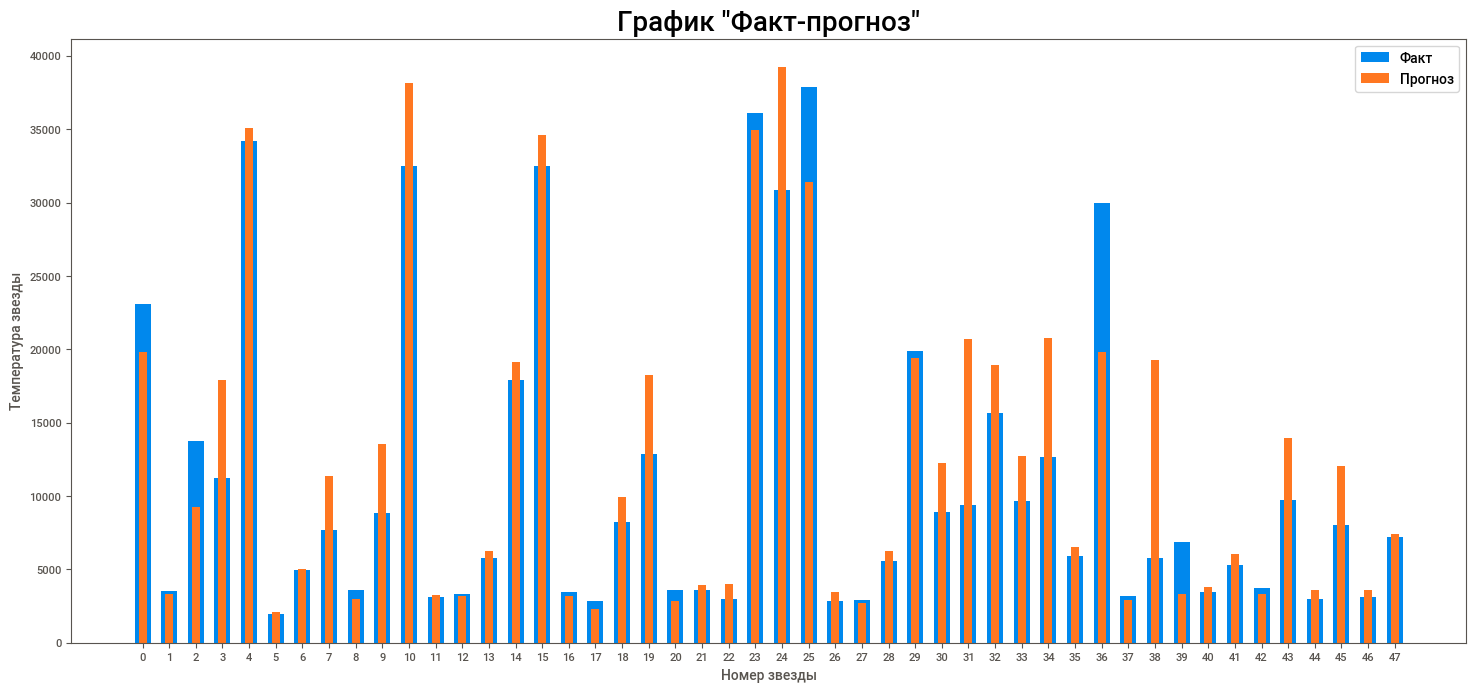

In [54]:
vizualization(predicted_temp, y_test)

Вывод

Проведено обучение baseline без дополнительных введений и перебора параметров. Лучшая метрика RMSE до начала переобучения равна 4244. Однако, это не лучший результат, которого мы можем добиться, далее будем улучшаять нашу НС. Судя по графику факт-прогноз мы отлично угадываем температуру звёзд с минимальным отклонением до 5000 градусов по Кельвину. Далее алгоритм начинает брать то выше правильного ответа, то ниже, скорее всего это связано с небольшим количеством подобных звёзд в нашей выборке, НС просто не смогла правильно научиться на таком малом количестве данных.

## Улучшение нейронной сети

Для улучшения нейронной сети попробуем методы Batch Normalization и Dropout, а также подберем оптимальное количество эпох обучения, а также определим лучший оптимизатор и проверим, позволят ли данные методы улучшить нашу нейронную сеть.

In [55]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 12
n_hidden_neurons_2 = 8
n_out_neurons = 1

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
optimizer1 = torch.optim.Adam(net.parameters(), lr=1e-3)
optimizer2 = torch.optim.NAdam(net.parameters(), lr=1e-2)
optimizer3 = torch.optim.Adamax(net.parameters(), lr=1e-2)
optimizer4 = torch.optim.Adamax(net.parameters(), lr=1e-3)
optimizer5 = torch.optim.Adam(net.parameters(), lr=1e-2)

optimizers = [optimizer1, optimizer2, optimizer3, optimizer4, optimizer5]

In [57]:
rmse_optimizers = []
for optimizer in optimizers:
    print(optimizer)
    print()

    early_stopping = CustomEarlyStopping(patience=5, min_delta=20)

    num_epochs = 100001
    for epoch in range(num_epochs):
        net.train()
        for batch in train_dataloader:
            data_train, temperature_train = batch # просто выгружаем данные 
            optimizer.zero_grad()

            preds = net.forward(data_train).flatten()

            loss_value = torch.sqrt(loss(preds, temperature_train))
            loss_value.backward()
            optimizer.step()

        if epoch % 200 == 0:
            predicted_temp = [] 
            with torch.no_grad():
                net.eval()
                for batch in test_dataloader:
                    data_test, temperature_test = batch # просто выгружаем данные

                    test_preds = net.forward(data_test).flatten()
                    predicted_temp.append(test_preds)
                    RMSE_loss = torch.sqrt(loss(test_preds, temperature_test))

            predicted_temp = torch.cat(predicted_temp).detach().numpy()
            RMSE = mean_squared_error(y_test, predicted_temp, squared=False)
            early_stopping(RMSE)
            if early_stopping.counter == 0:
                best_rmse = RMSE
                best_predicted_temp = predicted_temp
            print(f"epoch:{epoch}, RMSE test: {RMSE}")

            if early_stopping.early_stop:
                print('Early Stoppning!!!')
                print(f'Best RMSE test {best_rmse}')
                rmse_optimizers.append(round(best_rmse, 2))
                break 

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

epoch:0, RMSE test: 15201.00390625
epoch:200, RMSE test: 14442.33984375
epoch:400, RMSE test: 10906.923828125
epoch:600, RMSE test: 8102.01123046875
epoch:800, RMSE test: 7437.15087890625
epoch:1000, RMSE test: 6997.0458984375
epoch:1200, RMSE test: 6555.15625
epoch:1400, RMSE test: 6157.4365234375
epoch:1600, RMSE test: 5828.470703125
epoch:1800, RMSE test: 5586.12890625
epoch:2000, RMSE test: 5422.10302734375
epoch:2200, RMSE test: 5313.13232421875
epoch:2400, RMSE test: 5236.13720703125
epoch:2600, RMSE test: 5173.09814453125
epoch:2800, RMSE test: 5118.92724609375
epoch:3000, RMSE test: 5053.2255859375
epoch:3200, RMSE test: 5003.16552734375
epoch:3400, RMSE test: 4959.646484375
epoch:3600, RMSE test: 4919.55615234375
epoch:3800, RMSE test: 4885.2685546875
epoch:4000, RMSE test: 4854.158203125
epoch:4200, RMSE test: 4832.6513671875
epoch:4400, RMSE test: 4809.1513

In [58]:
optimizers_rmse = pd.DataFrame(data = rmse_optimizers, index = ['Adam, lr: 0.001',
                                                                'NAdam, lr: 0.01',
                                                                'Adamax, lr: 0.01',
                                                                'Adamax, lr: 0.001',
                                                                'Adam, lr: 0.01'], columns = ['RMSE'])
display(optimizers_rmse.sort_values(by='RMSE'))

,RMSE
"NAdam, lr: 0.01",4027.350098
"Adamax, lr: 0.01",4117.419922
"Adam, lr: 0.01",4234.009766
"Adamax, lr: 0.001",4313.310059
"Adam, lr: 0.001",4663.629883


Попробуем метод Dropout на разных слоях, проверим, позволит ли это улучшить нашу нейронную сеть.

In [59]:
rmse_dropouts = [4205, 3923, 4007, 4035, 4197, 4010, 3996, 3943]
dropouts_rmse = pd.DataFrame(data = rmse_dropouts, index = ['Dropout, dp1: 0.7',
                                                                'Dropout, dp1: 0.5',
                                                                'Dropout, dp1: 0.2',
                                                                'Dropout, dp1: 0.1',
                                                                'Dropout, dp1: 0.5, dp2: 0.4',
                                                                'Dropout, dp1: 0.5, dp2: 0.3',
                                                                'Dropout, dp1: 0.5, dp2: 0.2',
                                                                'Dropout, dp1: 0.5, dp2: 0.1',
                                                               ], columns = ['RMSE'])
display(dropouts_rmse.sort_values(by='RMSE'))

,RMSE
"Dropout, dp1: 0.5",3923
"Dropout, dp1: 0.5, dp2: 0.1",3943
"Dropout, dp1: 0.5, dp2: 0.2",3996
"Dropout, dp1: 0.2",4007
"Dropout, dp1: 0.5, dp2: 0.3",4010
"Dropout, dp1: 0.1",4035
"Dropout, dp1: 0.5, dp2: 0.4",4197
"Dropout, dp1: 0.7",4205


Лучший результат по скорости и метрике получилось достичь используя метод Dropout после первого слоя со значением 0.5.

Добавим регуляризацию на лучшем оптимизаторе NAdam, lr: 0.01 и метод Dropout после первого скрытого слоя (0.5)

In [60]:


class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
            super(Net, self).__init__()
            
            self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
            self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
            self.act1 = nn.ReLU()
            self.dp1 = nn.Dropout(p=0.5)
            self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
            self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
            self.act2 = nn.ReLU()
            self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
            
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.fc3(x)
        
        return x

In [61]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 12
n_hidden_neurons_2 = 8
n_out_neurons = 1

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
optimizer = torch.optim.NAdam(net.parameters(), lr=1e-2)
loss = nn.MSELoss()

In [62]:
dataset_train = torch.utils.data.TensorDataset(X_train, y_train)
dataset_test = torch.utils.data.TensorDataset(X_test, y_test)

train_dataloader = DataLoader(dataset_train, batch_size=40, shuffle=True,
                              num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=40, num_workers=0) 

Обучим нейросеть.

In [63]:
early_stopping = CustomEarlyStopping(patience=10, min_delta=20)

num_epochs = 2001
val_loss = []
train_loss = []

for epoch in range(num_epochs):
    net.train()
    train_loss_batches = []
    for batch in train_dataloader:
        data_train, temperature_train = batch 
        optimizer.zero_grad()

        preds = net.forward(data_train).flatten()

        loss_value = torch.sqrt(loss(preds, temperature_train))
        
        loss_value.backward()
        optimizer.step()
        
        loss_value = loss_value.detach().numpy().reshape([-1])
        train_loss_batches.append(loss_value)
    
        
    if epoch % 50 == 0:
        predicted_temp = [] 
        with torch.no_grad():
            net.eval()
            for batch in test_dataloader:
                data_test, temperature_test = batch

                test_preds = net.forward(data_test).flatten()
                predicted_temp.append(test_preds)
                RMSE_loss = torch.sqrt(loss(test_preds, temperature_test))

        predicted_temp = torch.cat(predicted_temp).detach().numpy()
        RMSE = mean_squared_error(y_test, predicted_temp, squared=False)
        
        
        early_stopping(RMSE)
        if early_stopping.counter == 0:
            best_rmse = RMSE
            best_predicted_temp = predicted_temp
            val_loss.append(best_rmse)
            train_loss.append(np.mean(train_loss_batches))
        print(f"epoch:{epoch}, RMSE test: {RMSE}")
        
        
        if early_stopping.early_stop:
            print('Early Stoppning!!!')
            print(f'Best RMSE test {best_rmse}')
            break 

epoch:0, RMSE test: 15201.1025390625
epoch:50, RMSE test: 14977.8037109375
epoch:100, RMSE test: 14333.162109375
epoch:150, RMSE test: 13175.1962890625
epoch:200, RMSE test: 12047.6748046875
epoch:250, RMSE test: 10155.1259765625
epoch:300, RMSE test: 8990.423828125
epoch:350, RMSE test: 6686.400390625
epoch:400, RMSE test: 5499.49755859375
epoch:450, RMSE test: 4309.1708984375
INFO: Early stopping counter 1 of 10
epoch:500, RMSE test: 4347.82861328125
epoch:550, RMSE test: 4004.60888671875
epoch:600, RMSE test: 3953.599853515625
INFO: Early stopping counter 1 of 10
epoch:650, RMSE test: 4174.96142578125
INFO: Early stopping counter 2 of 10
epoch:700, RMSE test: 3993.664794921875
INFO: Early stopping counter 3 of 10
epoch:750, RMSE test: 4077.647705078125
INFO: Early stopping counter 4 of 10
epoch:800, RMSE test: 4047.401611328125
INFO: Early stopping counter 5 of 10
epoch:850, RMSE test: 4142.98876953125
INFO: Early stopping counter 6 of 10
epoch:900, RMSE test: 4059.132080078125
INFO

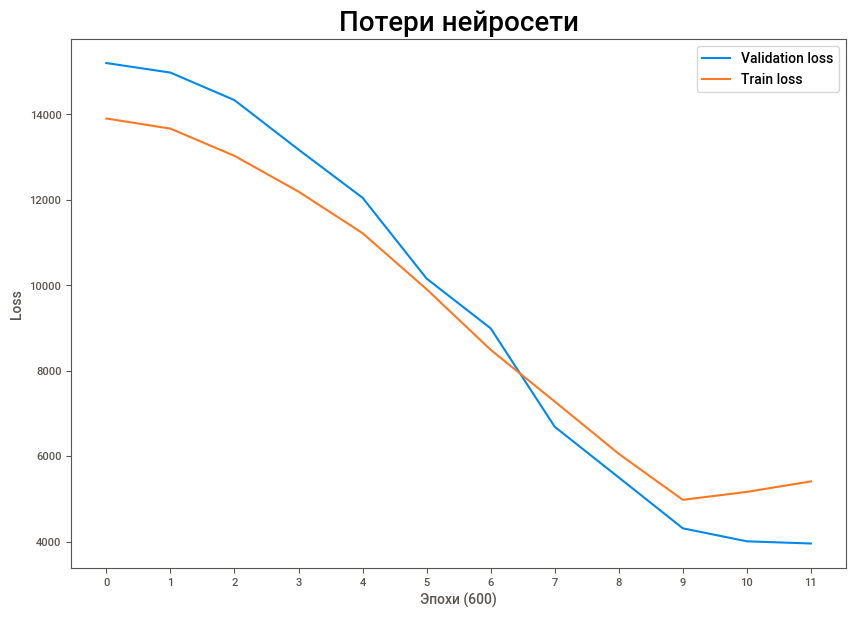

In [64]:
x = np.arange(len(val_loss))

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(7)
ax.set_xticks(x)
val = ax.plot(x, val_loss, label = 'Validation loss')
train = ax.plot(x, train_loss, label = 'Train loss')
ax.legend()
ax.set_title('Потери нейросети', fontsize=20)
ax.set_xlabel('Эпохи (600)')
ax.set_ylabel('Loss')
plt.show()

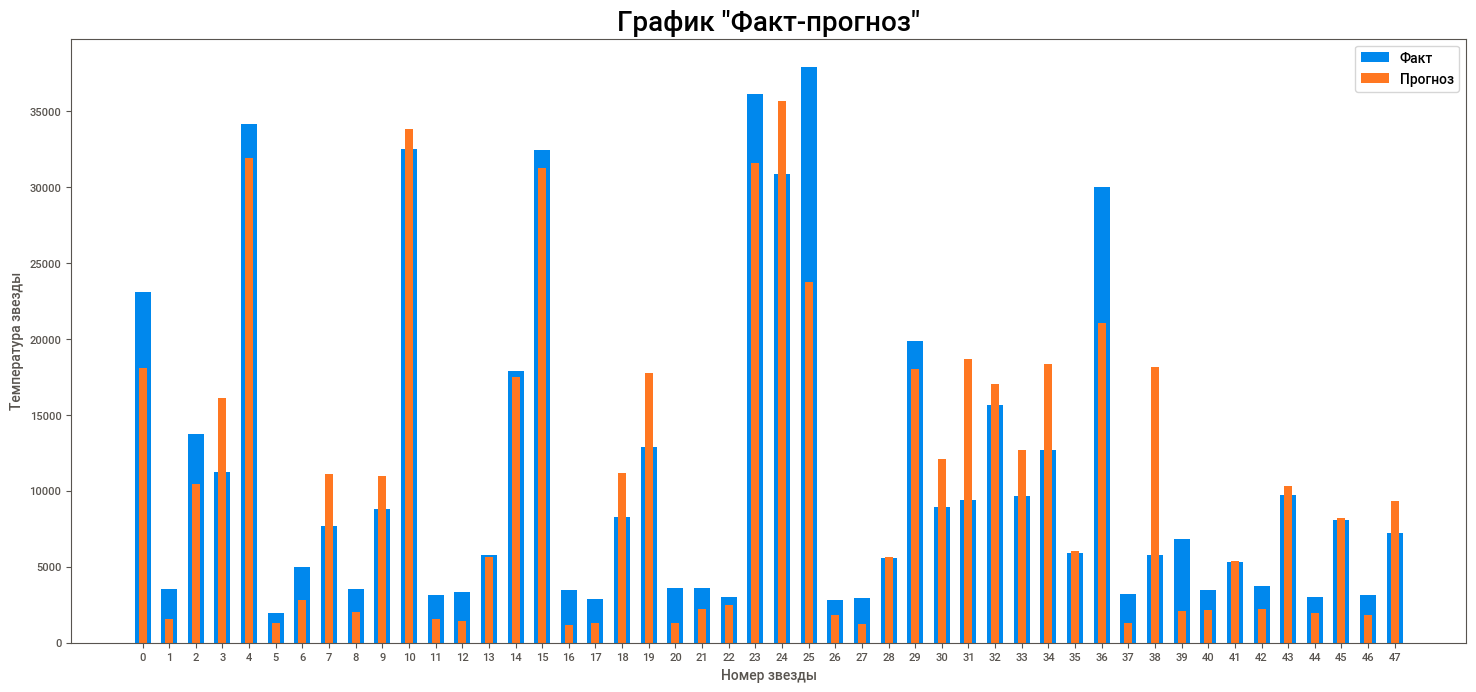

In [65]:
vizualization(predicted_temp, y_test)

Проведем перебор оптимизаторов, для выявления лучшего из 5 представленных, с учётом шага. Судя по метрикам, лучшим оптимизатором для этой задачи является NAdam с шагом равной одной сотой (RMSE = 4027). На нём мы провели конечное улучшение модели: добавили dropout равный 50% и регуляризацию весов BatchNorm1d на первый и второй скрытый слой. Время обучения сильно увеличилась, однако это способстовало улучшению метрики. Конечная метрика RMSE в улучшенной НС равна 3953. Если посмотреть на график потерь нашей последней нейросети, то можно увидеть, что модель обучилась качественно, без недо/переобучений, благодаря ранней остановке.

## Выводы

В проекте разработана нейронная сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.

В ходе работы были проанализированы исходные данные, а также проведена их подготовка к работе.По результатам предобработки данных были исправлены ошибки в столбце Star color, связанные с неявными дубликатами в словах, что позволило сократить количество уникальных значений с 19 до 12 штук. Названия столбцов были приведены к принятому виду. Явные дубликаты и пропуски в данных не были обнаружены. Разделили данные на выборки, на признаки и цели.

Рассмотрено распределение данных в столбцах с применением метода sweetwiz. Распределения количественных данных сложно отнести к какому-то типу, слишком мало данных. Количественные данные выглядят правдивыми относительно своей природы.
Распределение объектов по типам звёзд равномерное.

Рассмотрена связь целевого показателя с признаками. Отмечается мультикорреляция между столбцом Star type и Absolute magnitude(Mv), равная 92% по корреляции phik.

Исследовали базовые архитектуры нейронных сетей из 1 и 2  слоёв с разными функциями активациями. Оценили их эффективность по метрике RMSE. Проведено обучение baseline без дополнительных введений и перебора параметров. Лучшая метрика RMSE до начала переобучения равна 4675. Однако, это не лучший результат, которого можно добиться. Судя по графику факт-прогноз мы отлично угадываем температуру звёзд с минимальным отклонением до 5000 градусов по Кельвину. Далее алгоритм начинает ошибаться, скорее всего это связано с небольшим количеством подобных звёзд в нашей выборке, НС просто не смогла правильно научиться на таком малом количестве данных.

Проведен перебор оптимизаторов, для выявления лучшего из 5 представленных, с учётом шага. Судя по метрикам, лучшим оптимизатором для этой задачи является NAdam с шагом равной одной сотой (RMSE = 4027). На нём мы провели конечное улучшение модели: добавили dropout равный 50% и регуляризацию весов BatchNorm1d на первый и второй скрытый слой. Время обучения сильно увеличилась, однако это способстовало улучшению метрики. Конечная метрика RMSE в улучшенной НС равна 3953. Если посмотреть на график потерь нашей последней нейросети, то можно увидеть, что модель обучилась качественно, без недо/переобучений, благодаря ранней остановке.